In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import time
import pickle

import MNISTh
from MNISTh.ConvNet import ConvNet
from MNISTh.utils import loss_and_accuracy, single_epoch_training

BATCH_SIZE = 2**6
PRINT_EVERY = 100
N_EPOCHS = 1
LR = np.power(10.0,-2.6)

In [2]:
orig_trainset = MNISTh.trainloader
orig_testset = MNISTh.testloader

n_data_repeats = 4

from torch.utils.data import ConcatDataset
def concat_loader(data_loader, n):
    ds = data_loader.dataset
    duplicated_ds = ConcatDataset([ds] * 4)
    return DataLoader(duplicated_ds, batch_size=data_loader.batch_size, shuffle=True)

trainloader = concat_loader(orig_trainset, n_data_repeats)
testloader = concat_loader(orig_testset, n_data_repeats)

In [36]:
def test_accuracies(
    this_model, 
    trainloader,
    testloader,
    data_ratios_eval,
    batch_size = BATCH_SIZE,
    lr = LR, 
    print_every=PRINT_EVERY, 
    verbose=True,
    seed = None
):
    seed = seed or int(time.time()*1e6 % 100000)
    generator = torch.Generator().manual_seed(seed)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(this_model.parameters(), lr=LR)
    
    n_batches = trainloader.__len__()
    stop_points = { int(n_batches*np.power(2.0,-ratio))-1 for ratio in data_ratios_eval }
    test_results = {}
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = this_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i in stop_points:
            test_results[i] = loss_and_accuracy(this_model, testloader, criterion)
            
    return test_results

In [37]:
import pickle
import os

def scaling_experiment(
    out_dict,
    model_exps, 
    data_recip_exps,
    n_repeats = 1, 
    seed = None, 
    batch_size = BATCH_SIZE,
    lr = LR, 
    print_every=PRINT_EVERY, 
    verbose=True,
    save_folder = None
):
    if save_folder:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        save_ix = 0
            
    seed = seed or int(time.time()*1e6 % 100000)
    for j in model_exps:
        for k in range(n_repeats):
            this_model = ConvNet(scale_power = j)
            lr_adjustment = np.power(2.0, -j/4)
            print(f"Model exponent: {j}, Repeat: {k}")
            this_accuracy = test_accuracies(
                this_model, 
                trainloader,
                testloader,
                data_ratios_eval = data_recip_exps,
                lr = lr * lr_adjustment
            )
            for key, item in this_accuracy.items():
                out_dict[(j,k,key)] = item
        if save_folder:
            with open(f"{save_folder}/{save_ix}.pkl", 'wb') as f:
                pickle.dump(out_dict, f)
            print(f"saved to {save_folder}")
            save_ix += 1
    return out_dict        

In [83]:
data_recip_exps = np.arange(8)
model_exps = np.arange(6)
n_repeats = 10

accuracies = {}
se = scaling_experiment(
    accuracies,  
    model_exps, 
    data_recip_exps, 
    n_repeats = n_repeats,
    save_folder = "scaling_exp_results_2024_03_29-2")

Model exponent: 0, Repeat: 0
Model exponent: 0, Repeat: 1
Model exponent: 0, Repeat: 2
Model exponent: 0, Repeat: 3
Model exponent: 0, Repeat: 4
Model exponent: 0, Repeat: 5
Model exponent: 0, Repeat: 6
Model exponent: 0, Repeat: 7
Model exponent: 0, Repeat: 8
Model exponent: 0, Repeat: 9
saved to scaling_exp_results_2024_03_29-2
Model exponent: 1, Repeat: 0
Model exponent: 1, Repeat: 1
Model exponent: 1, Repeat: 2
Model exponent: 1, Repeat: 3
Model exponent: 1, Repeat: 4
Model exponent: 1, Repeat: 5
Model exponent: 1, Repeat: 6
Model exponent: 1, Repeat: 7
Model exponent: 1, Repeat: 8
Model exponent: 1, Repeat: 9
saved to scaling_exp_results_2024_03_29-2
Model exponent: 2, Repeat: 0
Model exponent: 2, Repeat: 1
Model exponent: 2, Repeat: 2
Model exponent: 2, Repeat: 3
Model exponent: 2, Repeat: 4
Model exponent: 2, Repeat: 5
Model exponent: 2, Repeat: 6
Model exponent: 2, Repeat: 7
Model exponent: 2, Repeat: 8
Model exponent: 2, Repeat: 9
saved to scaling_exp_results_2024_03_29-2
Mode

In [136]:
# with open("09_28_yesdropout", 'rb') as f:
#     accuracies = pickle.load(f)
with open("scaling_exp_results_2024_03_29-2/5.pkl", 'rb') as f:
    accuracies = pickle.load(f)

In [138]:
n_batches = np.sort(list({ sz for (_, _, sz) in accuracies.keys() }))

accuracies_array = np.zeros([len(model_exps), len(data_recip_exps), n_repeats])

for i in range(len(model_exps)):
    for j in range(len(n_batches)):
        for k in range(n_repeats):
            sz = list(n_batches)[j]
            exp = model_exps[i]
            # try:
            accuracies_array[i,j,k] += accuracies[(exp,k,sz)][0]
            # except KeyError:
            #     pass

accuracies_array = np.log(accuracies_array)

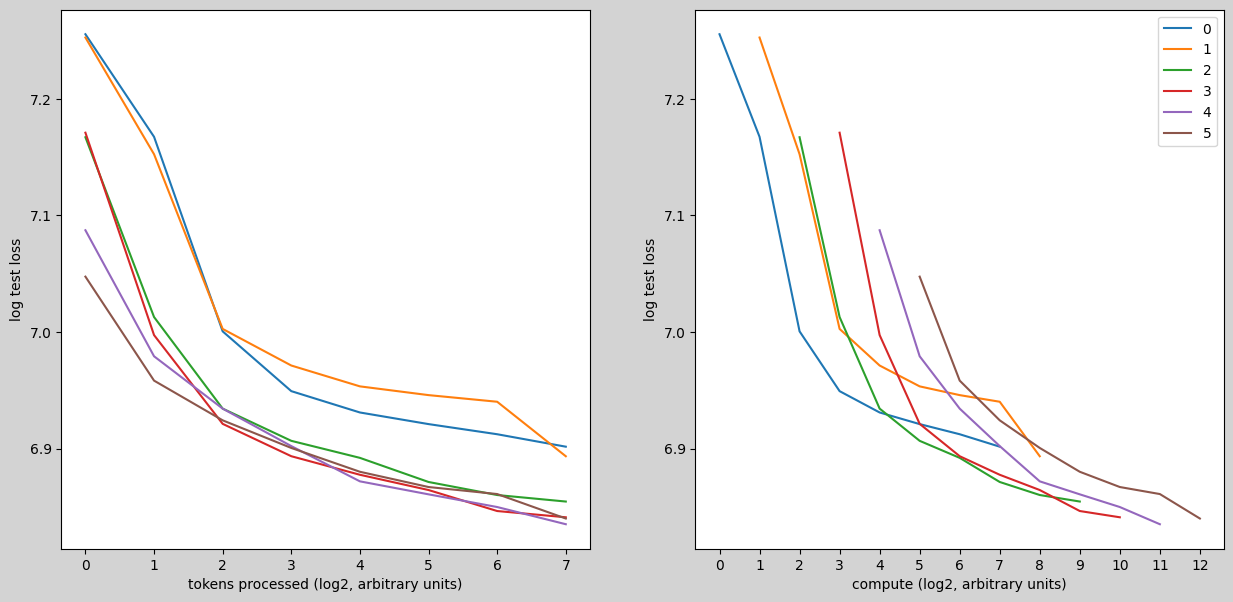

In [142]:
#compare to figure 2 in the Kaplan paper
means = np.mean(accuracies_array,2)
sem = np.std(accuracies_array,2) / np.sqrt(20)

fig, axs = plt.subplots(nrows = 1, ncols = 2, facecolor = "#d3d3d3", figsize = [15,7])

shifted_means = np.empty([6,13])
shifted_means[:,:] = np.nan
for i in range(means.shape[0]):
    shifted_means[i,i:i+8] = means[i,:]

axs[0].plot(np.arange(8),np.transpose(means));
axs[0].set_xticks(np.arange(8))
axs[0].set_xlabel("tokens processed (log2, arbitrary units)")
axs[0].set_ylabel("log test loss")
plt.legend(model_exps)


axs[1].plot(np.arange(13),np.transpose(shifted_means));
axs[1].set_xticks(np.arange(13))
axs[1].set_xlabel("compute (log2, arbitrary units)")
axs[1].set_ylabel("log test loss")
plt.legend(model_exps)
